# Analytical Task <a class='tocSkip'>

The table contains sample data from declarative surveys on jobs and employment for a specific group of people. The data is anonymous and covers current and expected incomes as well as commuting preferences. The data is not perfect and contains a bit of noise.

**Your task is to analyze the data and find the answers to three following questions:**

1. What is the distribution of the expected net income in relation to the current net income (charts + conclusions)?

2. What is the correlation between the desire to earn more and the possibility to commute longer (further away from home).

3. What is the key factor that determines the tendency to move closer to the work place (what is the most relevant factor influencing the will to move home closer work)?


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Feature importance seaerch libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Statistical tests
from scipy import stats

In [ ]:
# Loading data
df_raw = pd.read_excel('data/dataset.xlsx')

In [ ]:
# Quick look at data
df_raw.head(3)

In [ ]:
# Sorting rows by 'id'
df_raw.sort_values('id', ascending=True, inplace=True)
df_raw.reset_index(drop=True, inplace=True)
df_raw.head(3)

In [ ]:
# Setting proper column order, because they are mixed
living_distance_ix = df_raw.columns[df_raw.columns.str.contains('live')]
# df_raw[living_distance_ix].head(2)

commute_ix = df_raw.columns[df_raw.columns.str.contains('commute')]
# df_raw[commute_ix].head(2)

salary_ix = df_raw.columns[df_raw.columns.str.contains('salary')]
# df_raw[salary_ix].head(2)

get_ix = df_raw.columns[df_raw.columns.str.contains('get')]
# df_raw[get_ix].head(2)

# df_raw.iloc[:,:3].head(2)
# df_raw.iloc[:,-6:].head(2)

In [ ]:
df_raw.shape

In [ ]:
# New sorted dataframe
df = pd.concat([df_raw.iloc[:,:3],
               df_raw[living_distance_ix],
               df_raw[commute_ix],
               df_raw[salary_ix],
               df_raw[get_ix],
               df_raw.iloc[:,-6:]], axis=1)

In [ ]:
df.shape

In [ ]:
df.head(2)

Checking missing data distibution

In [ ]:
df_isnull = pd.DataFrame(df.isnull().sum())
df_isnull.reset_index(inplace=True)
df_isnull.columns = ['question','count']

In [ ]:
plt.figure(figsize=(8, 10))
sns.barplot(y='question', x='count', data=df_isnull, palette='icefire_r')
plt.xticks(rotation=90)
plt.title('Missing values');

In [ ]:
# First-glance statistics
df.describe(exclude='number')

# What is the distribution of the expected net income in relation to the current net income (charts + conclusions)?

<br><br><br>
**Conclusions:**<br><br>

* Most of the survey participants earn up to 1000 EUR per month. 
* Most of survey participants would like to earn between 2000 and 3000 EUR, but the runners-up got little bit lower expectations of 1000 to 1500 EUR. 
* Very few responders earn and would like to earn more than 6000 EUR.
<br><br>
* Overall tendency seems to be that the higher income the lower needs to earn more and the distribution starts to spread onto both higher but also lower expectations. Once they achieve top income levels (5000+ EUR) the tendency is to stay on this level but also looking for earning less. Whether this is due to overworking or some other circumstances is further to be analyzed. 

**Note:**
After differentiate the results with `gender` variable it turns out that the overall current income distribution in skewed. There is three times more women earning up to 1000 EUR than men in survey group, and going higher in salaries there is a raise of seven times more men earning 4000-5000 EUR than women. At the 3000+ EUR level there is significant drop in amount of female representatives so this could affect income expectiations results.


<br><br><br><br>

### Checking not-answered and multi-answered questions and ploting overall results

In [ ]:
# Helper function

def valid_answers_plot(group, plot_title):
    
    
    # Dropping useless observations because I cannot be sure of them
    group_inc = group[group.notnull().sum(axis=1) == 1]
    
    # Printing information about invalid entries
    print('Number of not-answered and multi-answered questions: {} of {}. \n \
           Ploting only valid {} entries'\
          .format(group[group.notnull().sum(axis=1) != 1].shape[0], group.shape[0],
                  group_inc.describe().T['count'].sum())) 

    # Ploting overall result
    plt.figure(figsize=(12,2))
    sns.barplot(x='count', y='index', data=group_inc.describe().T.reset_index(), palette='Set2')
    labels = group_inc.describe().T.reset_index()['index'].str.split('-', 1, expand=True)[1].values
    plt.yticks(rotation=0, ticks= range(len(labels)), labels=labels)
    plt.ylabel('Range')
    plt.xlabel('Frequency')
    plt.title(plot_title)
    plt.show()

In [ ]:
curr_double_answers_check = df.loc[:,'What is your current or previous monthly net salary - up to 1000 EUR':'What is your current or previous monthly net salary - refuse to answer']

Number of not-answered and multi-answered questions: 761 of 3692. 
            Ploting only valid 2931 entries


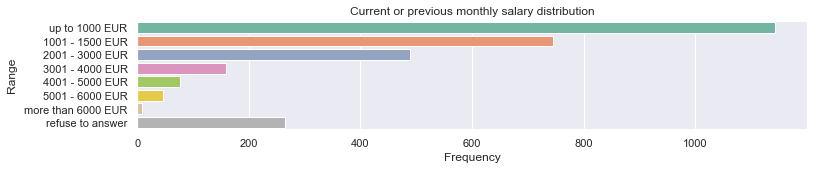

Sample invalid data


,What is your current or previous monthly net salary - up to 1000 EUR,What is your current or previous monthly net salary - 1001 - 1500 EUR,What is your current or previous monthly net salary - 2001 - 3000 EUR,What is your current or previous monthly net salary - 3001 - 4000 EUR,What is your current or previous monthly net salary - 4001 - 5000 EUR,What is your current or previous monthly net salary - 5001 - 6000 EUR,What is your current or previous monthly net salary - more than 6000 EUR,What is your current or previous monthly net salary - refuse to answer
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# Current or previous monthly net salary question
valid_answers_plot(curr_double_answers_check, 'Current or previous monthly salary distribution')
print('Sample invalid data')
curr_double_answers_check[curr_double_answers_check.notnull().sum(axis=1) != 1].head(2)

<br><br>
Most of the survey participants earn up to 1000 EUR per month.
<br><br><br>

In [ ]:
exp_double_answers_check = df.loc[:,'How much would you like to get monthly - up to 1000 EUR':'How much would you like to get monthly - refuse to answer']

Number of not-answered and multi-answered questions: 1497 of 3692. 
            Ploting only valid 2195 entries


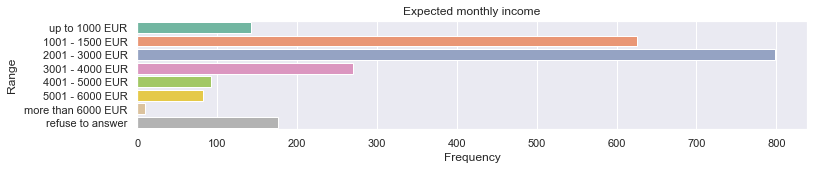

Sample invalid data


,How much would you like to get monthly - up to 1000 EUR,How much would you like to get monthly - 1001 - 1500 EUR,How much would you like to get monthly - 2001 - 3000 EUR,How much would you like to get monthly - 3001 - 4000 EUR,How much would you like to get monthly - 4001 - 5000 EUR,How much would you like to get monthly - 5001 - 6000 EUR,How much would you like to get monthly - more than 6000 EUR,How much would you like to get monthly - refuse to answer
0,NaN,sought-after job,sought-after job,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# Expected net monthly income
valid_answers_plot(exp_double_answers_check, 'Expected monthly income')
print('Sample invalid data')
exp_double_answers_check[exp_double_answers_check.notnull().sum(axis=1) != 1].head(2)

<br><br>
Most of survey participants would like to earn between 2000 and 3000 EUR, but there are many with little bit lower expectations of 1000 to 1500 EUR.
<br><br><br>

### Creating valid salary-themed dataframe without invalid answers

In [ ]:
curr_inc = curr_double_answers_check[curr_double_answers_check.notnull().sum(axis=1) == 1]
exp_inc = exp_double_answers_check[exp_double_answers_check.notnull().sum(axis=1) == 1]

In [ ]:
df_income = pd.concat([curr_inc, exp_inc], axis=1)
df_income = df_income[df_income.notnull().sum(axis=1) == 2]
df_income.head(2)

**Let's check which group wants to earn what amount of money**

In [ ]:
# Creating separate income groups
g1 = df_income[df_income['What is your current or previous monthly net salary - up to 1000 EUR'].notnull()].describe().T
g2 = df_income[df_income['What is your current or previous monthly net salary - 1001 - 1500 EUR'].notnull()].describe().T
g3 = df_income[df_income['What is your current or previous monthly net salary - 2001 - 3000 EUR'].notnull()].describe().T
g4 = df_income[df_income['What is your current or previous monthly net salary - 3001 - 4000 EUR'].notnull()].describe().T
g5 = df_income[df_income['What is your current or previous monthly net salary - 4001 - 5000 EUR'].notnull()].describe().T
g6 = df_income[df_income['What is your current or previous monthly net salary - 5001 - 6000 EUR'].notnull()].describe().T
g7 = df_income[df_income['What is your current or previous monthly net salary - more than 6000 EUR'].notnull()].describe().T
g8 = df_income[df_income['What is your current or previous monthly net salary - refuse to answer'].notnull()].describe().T

In [ ]:
# Helper function 

def expected_income_plot(group, column):
    
    plt.figure(figsize=(12,2))
    sns.barplot(x='count', y='index', data=group.loc['How much would you like to get monthly - up to 1000 EUR':,:]\
                .reset_index(), palette='Set2')
    labels = group.loc['How much would you like to get monthly - up to 1000 EUR':,:]\
                .reset_index()['index'].str.split('-', 1, expand=True)[1].values
    plt.yticks(rotation=0, ticks= range(len(labels)), labels=labels)
    plt.ylabel('Range')
    plt.xlabel('Frequency')
    plt.title('Earning currently {}, how much would you like to get?'.format(column.split('-',1)[1]))
    plt.show()

### Distribution of particular income groups and they expectations

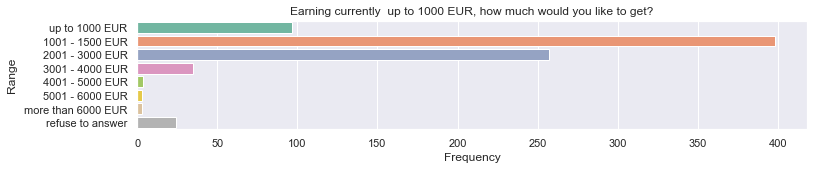

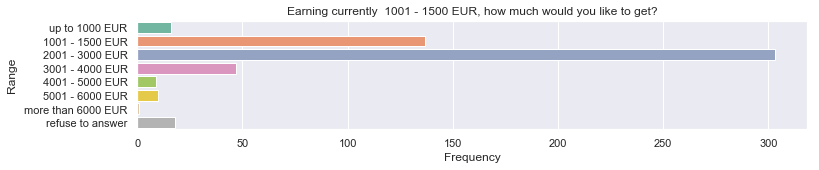

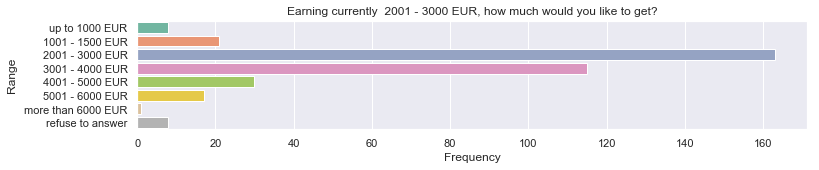

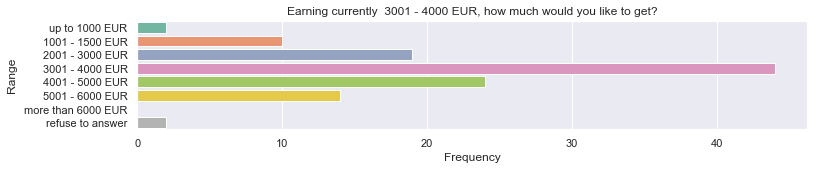

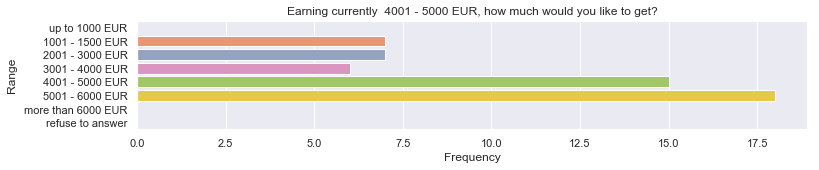

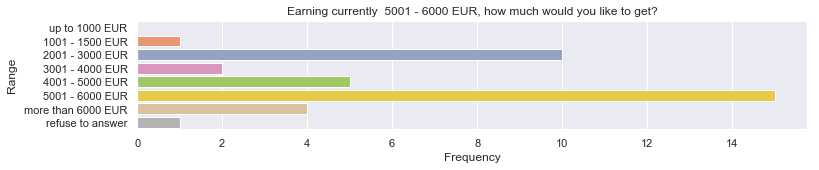

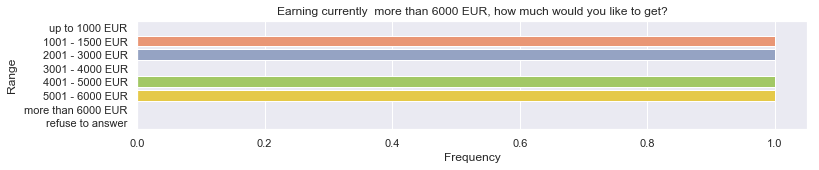

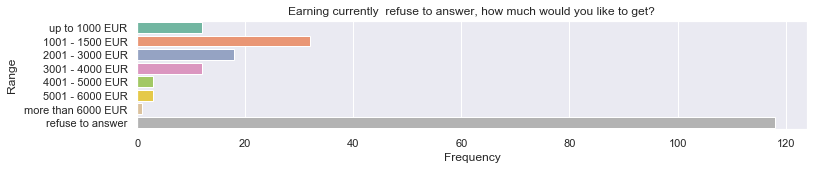

In [95]:
# Creating group list
g_list = [g1,g2,g3,g4,g5,g6,g7,g8]
col_list = np.array(df_income.columns[8:])

# Ploting results
for i in range(len(g_list)):
    expected_income_plot(g_list[i], col_list[i])

### Creating separated income-level groups

In [ ]:
# Creating group indexes
u1_ix = df_income[df_income['What is your current or previous monthly net salary - up to 1000 EUR'].notnull()].index
u2_ix = df_income[df_income['What is your current or previous monthly net salary - 1001 - 1500 EUR'].notnull()].index
u3_ix = df_income[df_income['What is your current or previous monthly net salary - 2001 - 3000 EUR'].notnull()].index
u4_ix = df_income[df_income['What is your current or previous monthly net salary - 3001 - 4000 EUR'].notnull()].index
u5_ix = df_income[df_income['What is your current or previous monthly net salary - 4001 - 5000 EUR'].notnull()].index
u6_ix = df_income[df_income['What is your current or previous monthly net salary - 5001 - 6000 EUR'].notnull()].index
u7_ix = df_income[df_income['What is your current or previous monthly net salary - more than 6000 EUR'].notnull()].index
u8_ix = df_income[df_income['What is your current or previous monthly net salary - refuse to answer'].notnull()].index

In [ ]:
# Creating groups
# Earning up to 1000 EUR
u1 = df[df.index.isin(u1_ix)]
# Earning between 1001-1500 EUR
u2 = df[df.index.isin(u2_ix)]
# ... and so on
u3 = df[df.index.isin(u3_ix)]
u4 = df[df.index.isin(u4_ix)]
u5 = df[df.index.isin(u5_ix)]
u6 = df[df.index.isin(u6_ix)]
u7 = df[df.index.isin(u7_ix)]
u8 = df[df.index.isin(u8_ix)]

In [ ]:
# Helper function

def income_group_plot(group):
    
    
    sns.countplot(group['D2# Gender'], palette='Set2')
    plt.title('')
    plt.show()

    order = ['yes','no']
    sns.countplot(x='Are you looking for a job?', hue='D2# Gender', data=group, order=order, palette='Set2')
    plt.show()
    
    order = ['yes','no']
    sns.countplot(x='Q13-C22 - Do you work currently? - Answer', hue='D2# Gender', data=group, order=order, palette='Set2')
    plt.show()
    
    order = ['yes','no']
    sns.countplot(x='Have you ever worked before?', hue='D2# Gender', data=group, order=order, palette='Set2')
    plt.show()

    order = ['yes','no']
    sns.countplot(x='Are you keen on moving closer to your work place?', hue='D2# Gender', data=group, order=order, palette='Set2')
    plt.show()

    plt.figure(figsize=(20,4))
    order = ['village','city up to 20k inhabitants','20k - 49k inhabitants','50k - 99k inhabitants',
                  '100k - 199k inhabitants','200k - 500k inhabitants','more than 500k inhabitants']
    sns.countplot(x='D1# City size', hue='D2# Gender', data=group, order=order, palette='Set2')
    plt.show()

    plt.figure(figsize=(20,4))
    order = ['less than 18 years','18 - 24 years','25 - 30 years','31 - 40 years','41 - 50 years','more than 50 years']
    sns.countplot(x='D3# Age', hue='D2# Gender', data=group, order=order, palette='Set2')
    plt.show()

    plt.figure(figsize=(20,4))
    order = ['basic','vocational','secondary', 'higher']
    sns.countplot(x='D4# Education', hue='D2# Gender', data=group, order=order, palette='Set2')
    plt.show()

## Selecting `gender` as a differentiating variable between groups

But the defferentiating variable could be city size, commute distance etc.

### Earning up to 1000 EUR

In [ ]:
# Helper function to differentiate income needs by gender

def income_needs_by_gender(main_group):
    
    # Selecting groups by gender
    female_group = main_group[main_group['D2# Gender'] == 'female'].describe(exclude='number').loc[:,'How much would you like to get monthly - up to 1000 EUR':'How much would you like to get monthly - refuse to answer':].T
    male_group = main_group[main_group['D2# Gender'] == 'male'].describe(exclude='number').loc[:,'How much would you like to get monthly - up to 1000 EUR':'How much would you like to get monthly - refuse to answer':].T
    
    i = 0
    for group in [female_group, male_group]:
        plt.figure(figsize=(12,2))
        sns.barplot(x='count', y='index', data=group.reset_index(),
                palette='Set2')
        labels = g1.loc['How much would you like to get monthly - up to 1000 EUR':,:]\
                    .reset_index()['index'].str.split('-', 1, expand=True)[1].values
        plt.yticks(rotation=0, ticks= range(len(labels)), labels=labels)
        plt.ylabel('Range')
        plt.xlabel('Frequency')
        plt.title('Female group income expectations') if i == 0 else plt.title('Male group income expectations')            
        plt.show()
        i += 1

In [ ]:
income_group_plot(u1)

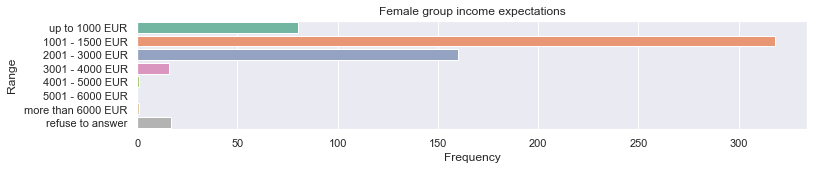

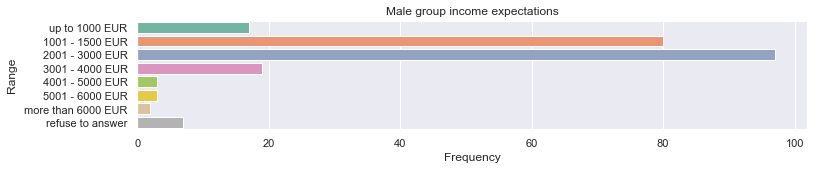

In [96]:
income_needs_by_gender(u1)

In [ ]:
# How far do they live from work
# u1.describe(exclude='number').loc[:,'How far do you live from current or previous work - less than 5 km':'How far do you live from current or previous work - more than 100 km'].T

In [ ]:
# How far are they able to commute?
# u1.describe(exclude='number').loc[:,'How far are you able to commute - less than 5 km':'How far are you able to commute - more than 100 km'].T

### Earning 1001-1500 EUR

In [ ]:
income_group_plot(u2)

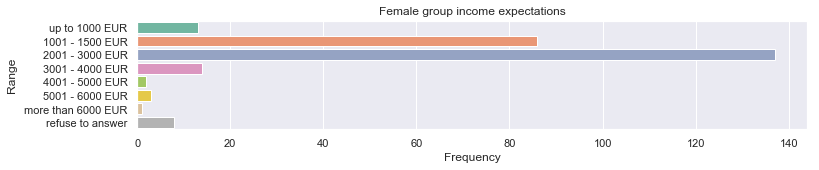

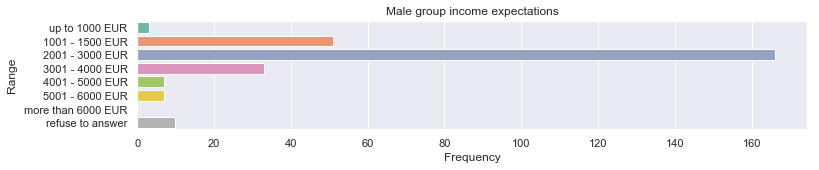

In [97]:
income_needs_by_gender(u2)

### Earning 2001-3000 EUR

In [ ]:
income_group_plot(u3)

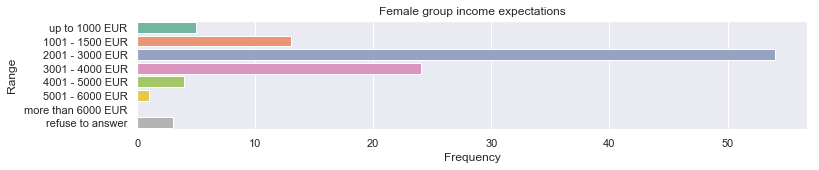

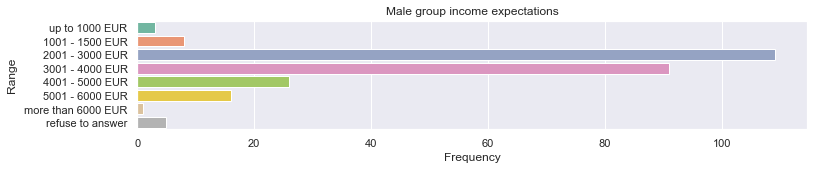

In [98]:
income_needs_by_gender(u3)

### Earning 3001-4000 EUR

In [ ]:
income_group_plot(u4)

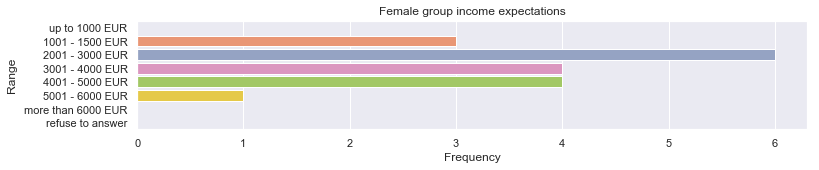

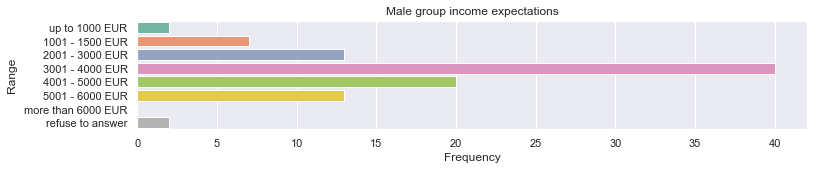

In [99]:
income_needs_by_gender(u4)

### Earning 4001-5000 EUR

In [ ]:
income_group_plot(u5)

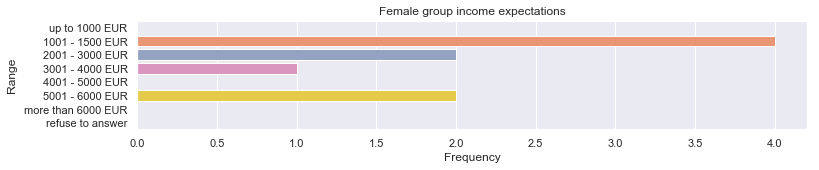

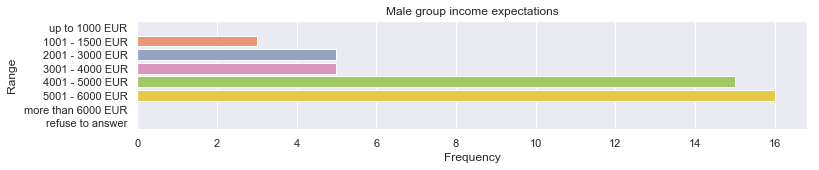

In [102]:
income_needs_by_gender(u5)

### Earning 5001-6000 EUR

In [ ]:
income_group_plot(u6)

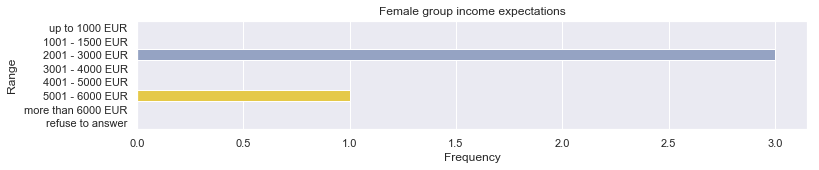

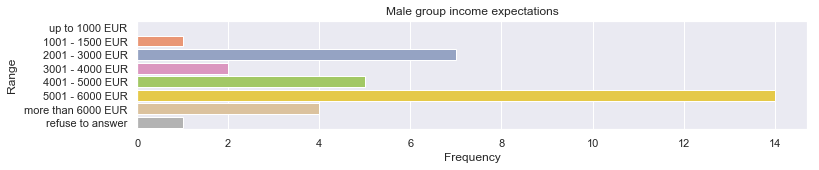

In [103]:
income_needs_by_gender(u6)

### Earning over 6000 EUR

In [ ]:
income_group_plot(u7)

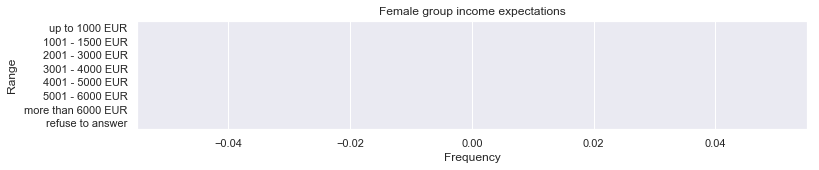

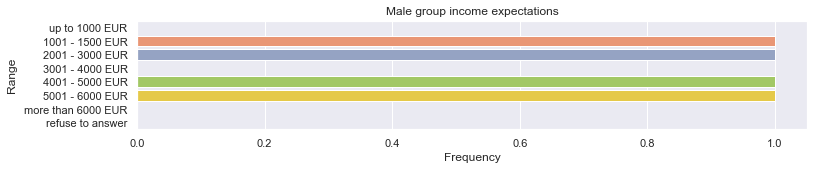

In [104]:
income_needs_by_gender(u7)

### Refused to answer how much do they earn currently

In [ ]:
income_group_plot(u8)

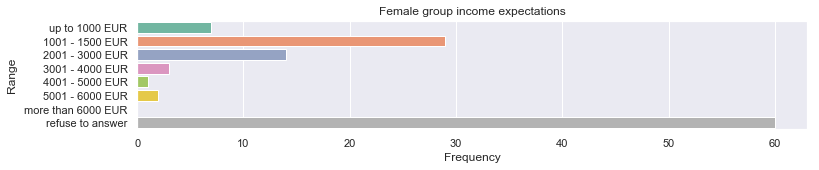

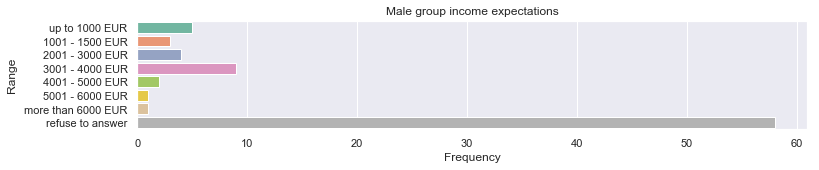

In [105]:
income_needs_by_gender(u8)

### Another solution to overall income and expectiations results divided by gender

In [ ]:
# Merging df_income dataframe into two columns

# Replacing values to some meaningfull ones in current income columns
df_income.iloc[:,0] = df_income.iloc[:,0].where(df_income.iloc[:,0].isnull(), 'up1000')
df_income.iloc[:,1] = df_income.iloc[:,1].where(df_income.iloc[:,1].isnull(), '1001-1500')
df_income.iloc[:,2] = df_income.iloc[:,2].where(df_income.iloc[:,2].isnull(), '2001-3000')
df_income.iloc[:,3] = df_income.iloc[:,3].where(df_income.iloc[:,3].isnull(), '3001-4000')
df_income.iloc[:,4] = df_income.iloc[:,4].where(df_income.iloc[:,4].isnull(), '4001-5000')
df_income.iloc[:,5] = df_income.iloc[:,5].where(df_income.iloc[:,5].isnull(), '5001-6000')
df_income.iloc[:,6] = df_income.iloc[:,6].where(df_income.iloc[:,6].isnull(), 'ovr6000')
df_income.iloc[:,7] = df_income.iloc[:,7].where(df_income.iloc[:,7].isnull(), 'refuse answ')
# Replacing values to some meaningfull ones in expected income columns
df_income.iloc[:,8] = df_income.iloc[:,8].where(df_income.iloc[:,8].isnull(), 'up1000')
df_income.iloc[:,9] = df_income.iloc[:,9].where(df_income.iloc[:,9].isnull(), '1001-1500')
df_income.iloc[:,10] = df_income.iloc[:,10].where(df_income.iloc[:,10].isnull(), '2001-3000')
df_income.iloc[:,11] = df_income.iloc[:,11].where(df_income.iloc[:,11].isnull(), '3001-4000')
df_income.iloc[:,12] = df_income.iloc[:,12].where(df_income.iloc[:,12].isnull(), '4001-5000')
df_income.iloc[:,13] = df_income.iloc[:,13].where(df_income.iloc[:,13].isnull(), '5001-6000')
df_income.iloc[:,14] = df_income.iloc[:,14].where(df_income.iloc[:,14].isnull(), 'ovr6000')
df_income.iloc[:,15] = df_income.iloc[:,15].where(df_income.iloc[:,15].isnull(), 'refuse answ')

In [ ]:
# Creating separate dataframes

# Current income 
df_income_curr = pd.DataFrame(df_income.loc[:,'What is your current or previous monthly net salary - up to 1000 EUR':'What is your current or previous monthly net salary - refuse to answer']\
                            .bfill(axis=1).iloc[:, 0])
df_income_curr.columns = ['Current Income']

# Expected income
df_income_exp = pd.DataFrame(df_income.loc[:,'How much would you like to get monthly - up to 1000 EUR':'How much would you like to get monthly - refuse to answer']\
                            .bfill(axis=1).iloc[:, 0])
df_income_exp.columns = ['Expected Income']

In [ ]:
# Mergind above columns together
df_income_ = pd.concat([df_income_curr, df_income_exp], axis=1)

In [ ]:
# Creating dataframe with only valid income-related answers, and then merging all columns into two
df_adult = pd.concat([df[df.index.isin(df_income_.index)], df_income_curr, df_income_exp], axis=1)
df_adult.head(1)

In [ ]:
# Dropping useless columns
cols = list(df_adult.loc[:,'What is your current or previous monthly net salary - up to 1000 EUR':'How much would you like to get monthly - refuse to answer'].columns)
df_adult.drop(cols, axis=1, inplace=True)
df_adult.head(1)

In [ ]:
# Helper function

def income_split_plot(split_column):
    
    order = ['up1000', '1001-1500', '2001-3000','3001-4000','4001-5000','5001-6000','ovr6000','refuse answ']
    plt.figure(figsize=(20, 6))
    sns.countplot(y='Current Income', hue=split_column, data=df_adult, order=order, palette='Set2')
    plt.show()
    plt.figure(figsize=(20, 6))
    sns.countplot(y='Expected Income', hue=split_column, data=df_adult, order=order, palette='Set2')
    plt.show()

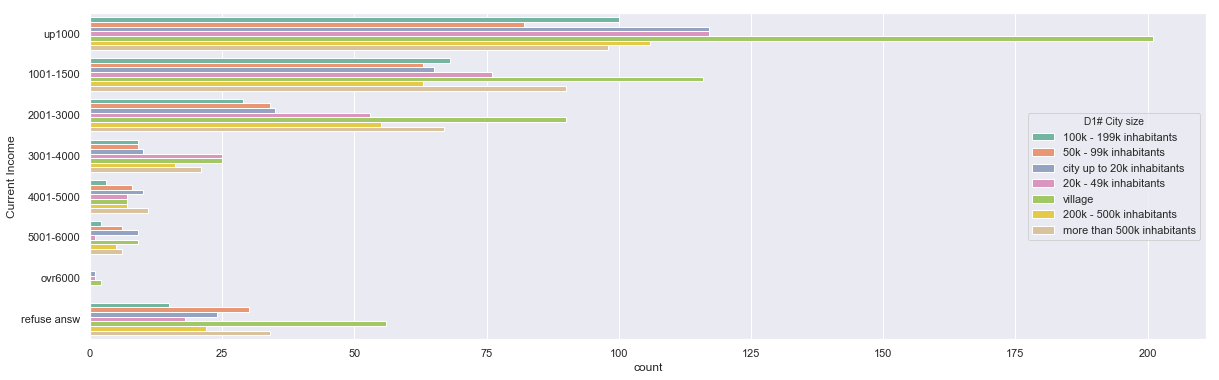

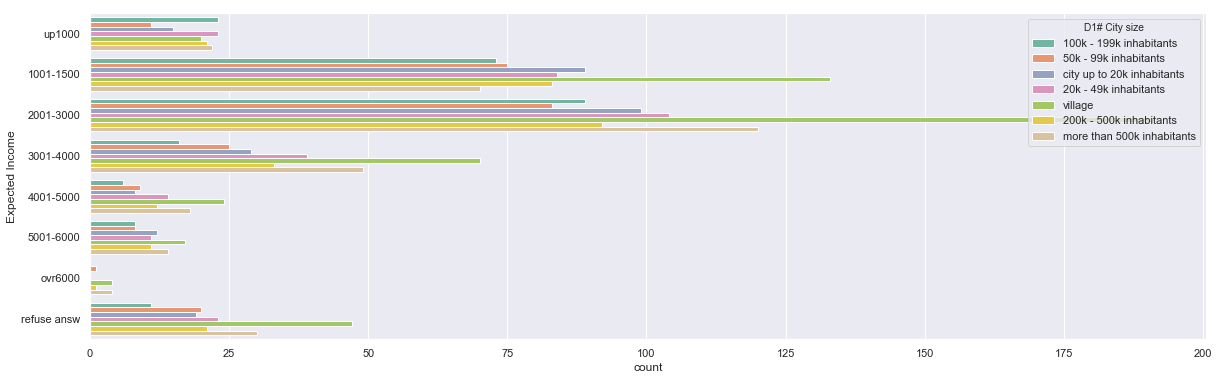

In [106]:
# Ploting data of interest
# The same can be done with different split method, eg. age or city size

income_split_plot('D1# City size')

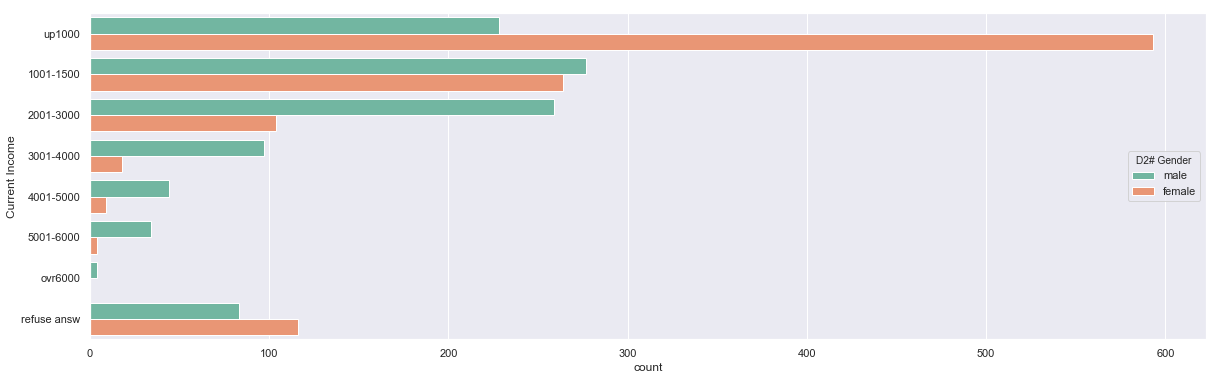

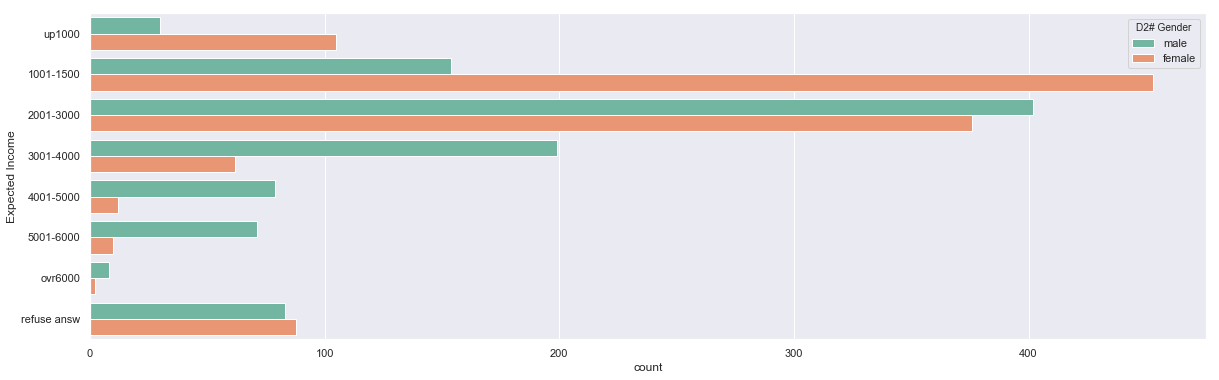

In [107]:
income_split_plot('D2# Gender')

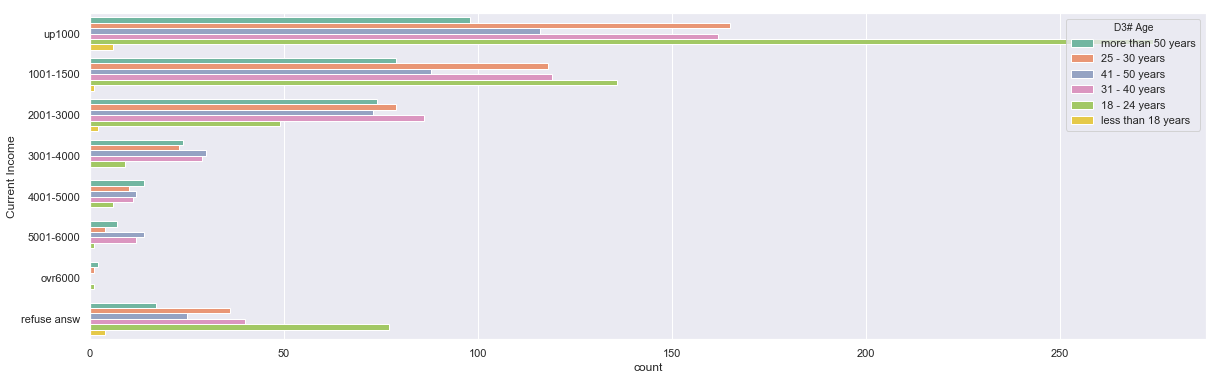

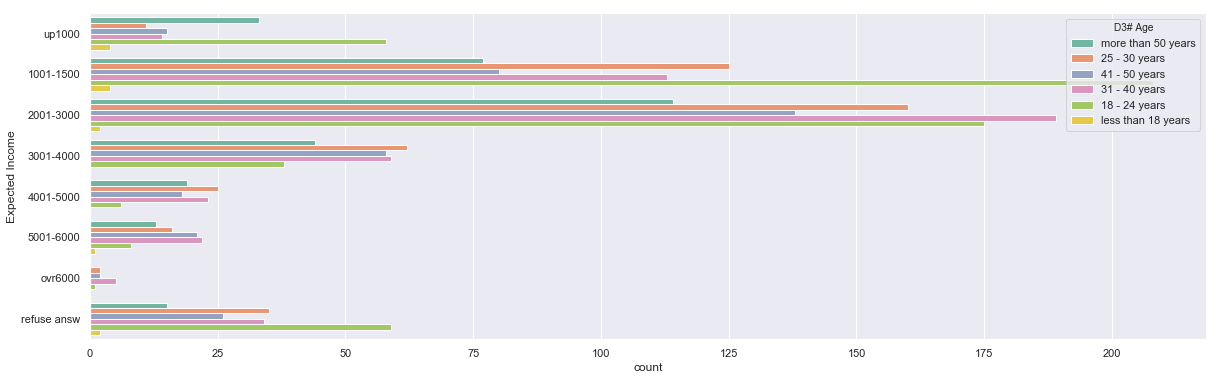

In [108]:
income_split_plot('D3# Age')

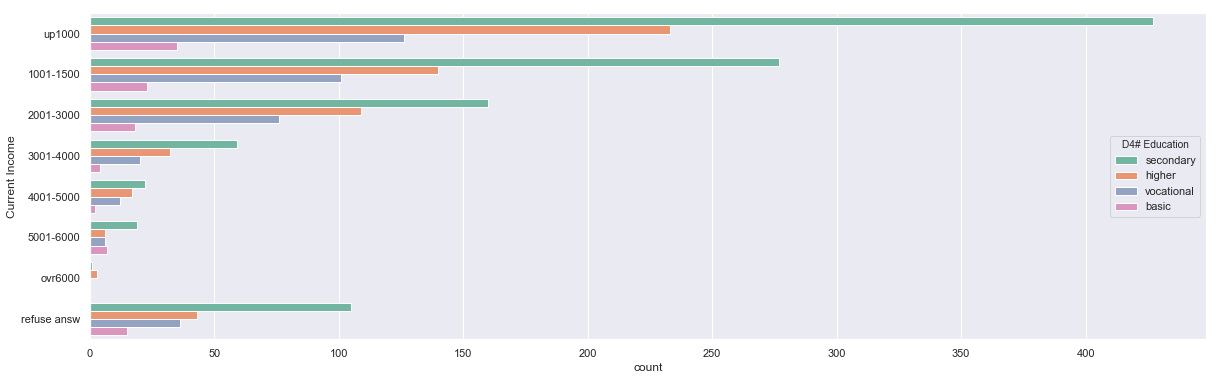

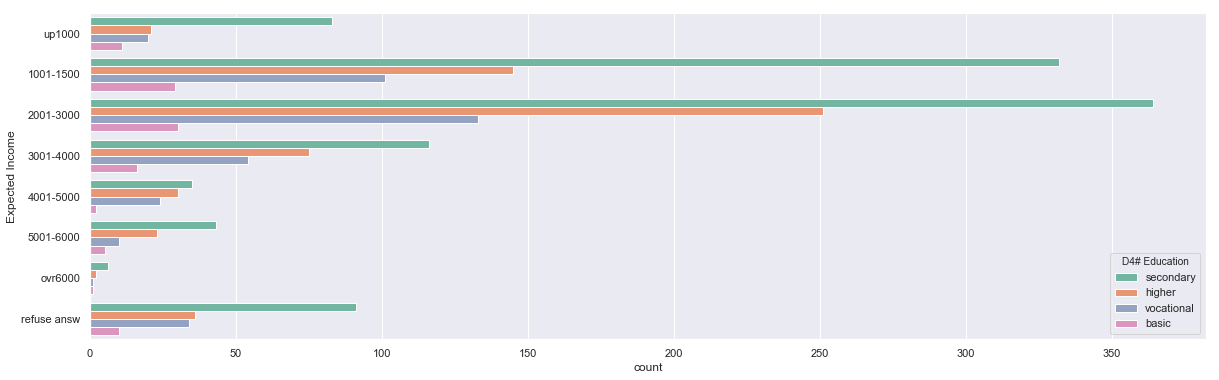

In [109]:
income_split_plot('D4# Education')

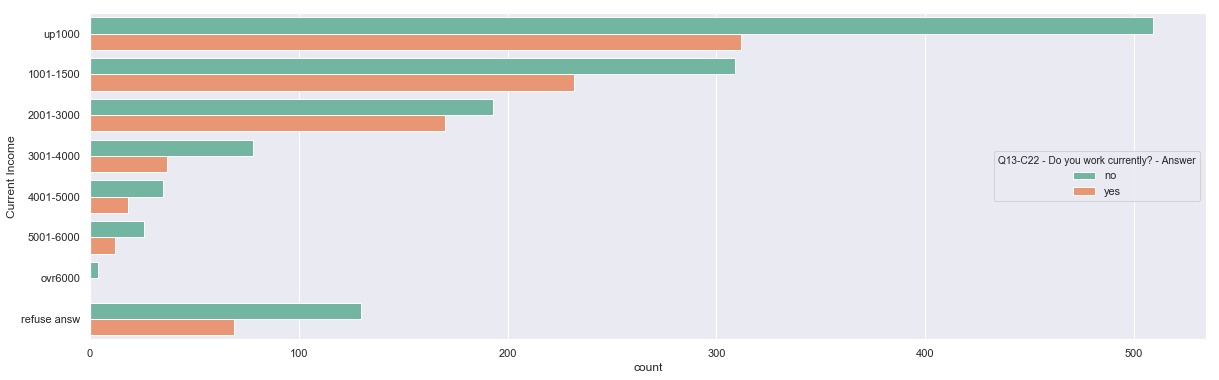

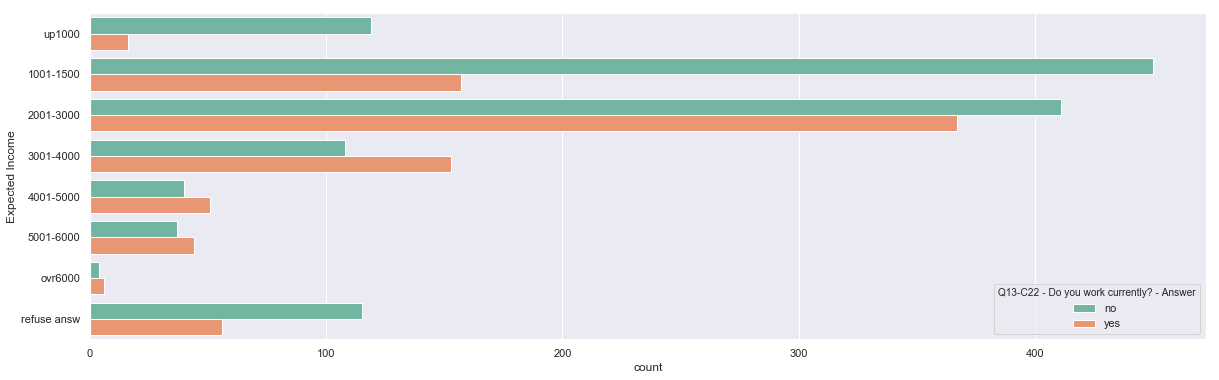

In [110]:
income_split_plot('Q13-C22 - Do you work currently? - Answer')

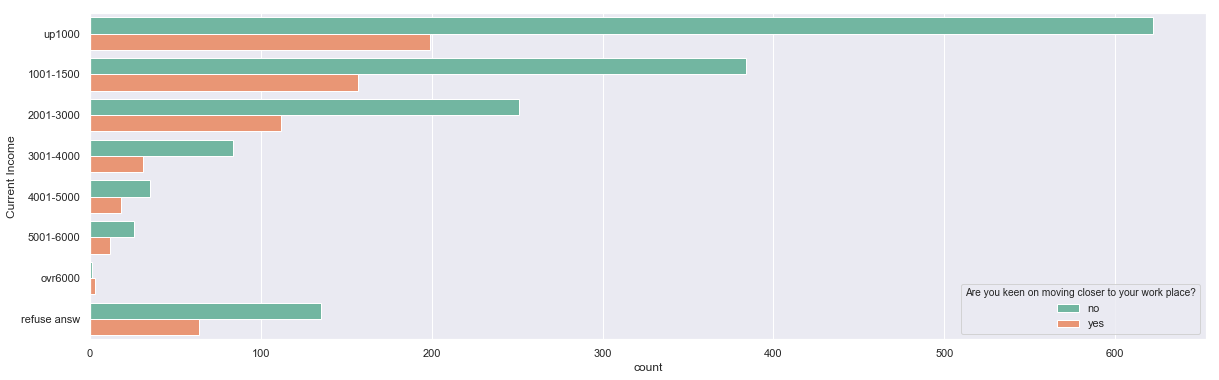

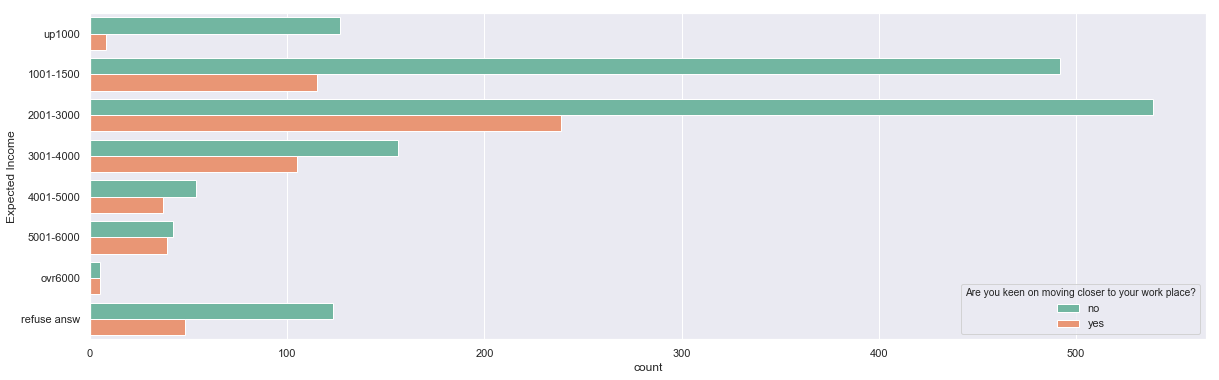

In [111]:
income_split_plot('Are you keen on moving closer to your work place?')

# What is the correlation between the desire to earn more and the possibility to commute longer (further away from home).

<br><br>
**Conclusions:**
<br>
It seems that with lower income expectations (up to 1500 EUR) the respondents would commute rather on closer distances (up to 5 km, but also slightly further like up to 10 km, but definetly not over 50 km). With the growing expectations (2000-3000 EUR) there is small tendency to commute little bit further (5-10 km or even up to 20 km). With even higher expectations (3000-4000 EUR) there is a little bit raise in a willingness to commute up to 50 km. After the income expectations reach 4000-5000 EUR the responders tend to commute rather either 10-20 or 20-50 km than less or more of that distance. For the expecting 5000-6000 EUR it nearly doesn't matter the distance to commute, and if expectations raise above that threshold it's become clear not to commute further than 50 km with the 10-20 km range in favour.

**Summarizing, with an increase in income expectations, the desire for further commuting also increases, but only up to a very high threshold when the distance becomes irrelevant. After that threshold it becomes very important not to commute on very far distances similarly as with the lowest income expectations**
<br><br>
**Note**:
When we split responders by gender we see that they mostly differ in expected income distribution but commuting patterns remain almost the same with tendency for men to commute further, even over 100 km when expecting middle level income and above.
<br><br>
Further analysis can be made taking into account city size, age and so on.
<br><br><br>

In [ ]:
# Checking no- and multi-answered observations and getting rid of them
live_double_answers_check = df_adult.loc[:,'How far do you live from current or previous work - less than 5 km':'How far do you live from current or previous work - more than 100 km']
commute_double_answers_check = df_adult.loc[:,'How far are you able to commute - less than 5 km':'How far are you able to commute - more than 100 km']

In [ ]:
# Living distance from current work
valid_answers_plot(live_double_answers_check, 'Living distance from current work')
print('Sample invalid data')
live_double_answers_check[live_double_answers_check.notnull().sum(axis=1) != 1].head(2)

In [ ]:
# Distance of willingness to commute to work
valid_answers_plot(commute_double_answers_check, 'Willingness to commute distance')
print('Sample invalid data')
commute_double_answers_check[commute_double_answers_check.notnull().sum(axis=1) != 1].head(2)

In [ ]:
# Selecting columns with one answer only
df_commute_ = commute_double_answers_check[commute_double_answers_check.notnull().sum(axis=1) == 1]
df_live_ = live_double_answers_check[live_double_answers_check.notnull().sum(axis=1) == 1]

In [ ]:
# Replacing values to some meaningfull ones in current income columns
df_live_.iloc[:,0] = df_live_.iloc[:,0].where(df_live_.iloc[:,0].isnull(), 'less 5')
df_live_.iloc[:,1] = df_live_.iloc[:,1].where(df_live_.iloc[:,1].isnull(), '5-10')
df_live_.iloc[:,2] = df_live_.iloc[:,2].where(df_live_.iloc[:,2].isnull(), '11-20')
df_live_.iloc[:,3] = df_live_.iloc[:,3].where(df_live_.iloc[:,3].isnull(), '21-50')
df_live_.iloc[:,4] = df_live_.iloc[:,4].where(df_live_.iloc[:,4].isnull(), '51-100')
df_live_.iloc[:,5] = df_live_.iloc[:,5].where(df_live_.iloc[:,5].isnull(), 'over 100')

# Replacing values to some meaningfull ones in expected income columns
df_commute_.iloc[:,0] = df_commute_.iloc[:,0].where(df_commute_.iloc[:,0].isnull(), 'less 5')
df_commute_.iloc[:,1] = df_commute_.iloc[:,1].where(df_commute_.iloc[:,1].isnull(), '5-10')
df_commute_.iloc[:,2] = df_commute_.iloc[:,2].where(df_commute_.iloc[:,2].isnull(), '11-20')
df_commute_.iloc[:,3] = df_commute_.iloc[:,3].where(df_commute_.iloc[:,3].isnull(), '21-50')
df_commute_.iloc[:,4] = df_commute_.iloc[:,4].where(df_commute_.iloc[:,4].isnull(), '51-100')
df_commute_.iloc[:,5] = df_commute_.iloc[:,5].where(df_commute_.iloc[:,5].isnull(), 'over 100')

In [ ]:
# Creating separate dataframes

# Current income 
df_live_ = pd.DataFrame(df_live_.loc[:,df_live_.columns[0]:df_live_.columns[5]].bfill(axis=1).iloc[:, 0])
df_live_.columns = ['Living distance']

# Expected income
df_commute_ = pd.DataFrame(df_commute_.loc[:,df_commute_.columns[0]:df_commute_.columns[5]].bfill(axis=1).iloc[:, 0])
df_commute_.columns = ['Able to commute']

In [ ]:
# Putting together commute-related 

df_living_commute = pd.concat([df_live_, df_commute_], axis=1)
df_living_commute = df_living_commute.dropna()
df_living_commute.head()

In [ ]:
df_adult.shape, df_living_commute.shape

In [ ]:
df_adult[df_adult.index.isin(df_living_commute.index)].shape

In [ ]:
# Creating dataframe with only valid income-related answers, and then merging all columns into two
df_adult_all = pd.concat([df_adult[df_adult.index.isin(df_living_commute.index)], df_living_commute], axis=1)
df_adult_all.head(1)

In [ ]:
# Dropping useless columns
cols = list(df_adult_all.loc[:,'How far do you live from current or previous work - less than 5 km':'How far are you able to commute - more than 100 km'].columns)
df_adult_all.drop(cols, axis=1, inplace=True)
df_adult_all.head(1)

**Plotting result for conclusions**

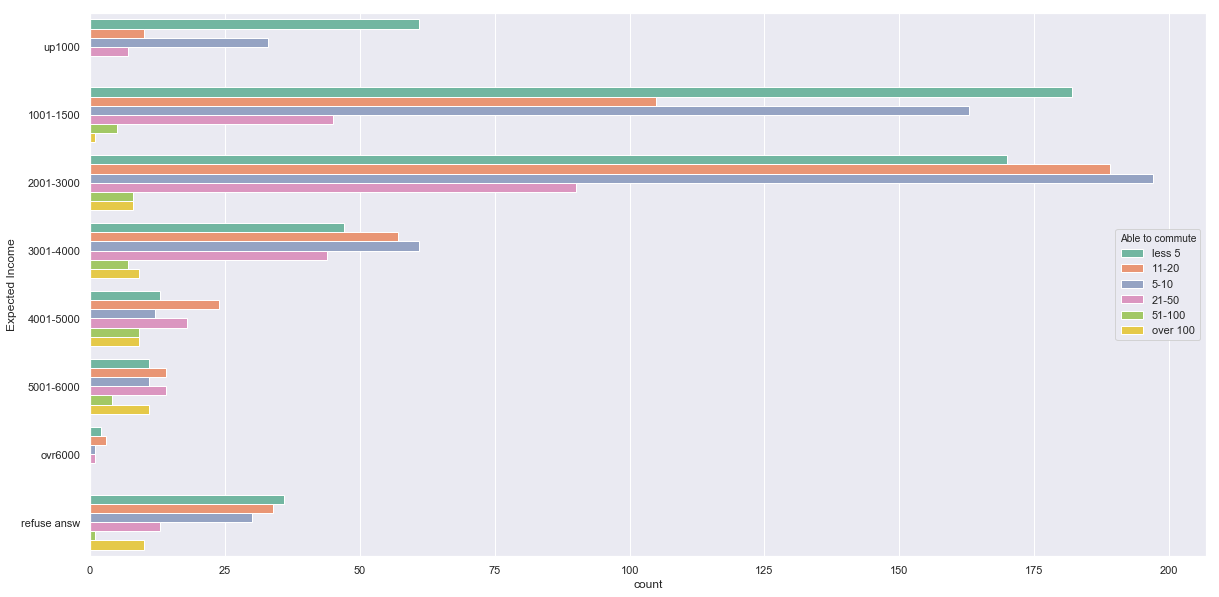

In [113]:
# Ploting results
order = ['up1000', '1001-1500', '2001-3000','3001-4000','4001-5000','5001-6000','ovr6000','refuse answ']
# order = ['less 5','5-10','11-20','21-50','51-100','over 100']
plt.figure(figsize=(20, 10))
sns.countplot(y='Expected Income', hue='Able to commute', data=df_adult_all, order=order, palette='Set2')
plt.show()

It seems that with lower income expectations (up to 1500 EUR) the respondents would commute rather on closer distances (up to 5 km, but also slightly further like up to 10 km, but definetly not over 50 km). With the growing expectations (2000-3000 EUR) there is small tendency to commute little bit further (5-10 km or even up to 20 km). With even higher expectations (3000-4000 EUR) there is a little bit raise in a willingness to commute up to 50 km. After the income expectations reach 4000-5000 EUR the responders tend to commute rather either 10-20 or 20-50 km than less or more of that distance. For the expecting 5000-6000 EUR it nearly doesn't matter the distance to commute, and if expectations raise above that threshold it's become clear not to commute further than 50 km with the 10-20 km range in favour.

**Looking at the gender split**

In [ ]:
df_adult_all['D2# Gender'].value_counts()

In [ ]:
# Helper function

def income_commute_plot(splitting_column):    
    order = ['up1000', '1001-1500', '2001-3000','3001-4000','4001-5000','5001-6000','ovr6000','refuse answ']
    sns.catplot(y="Expected Income", hue="Able to commute", col=splitting_column,
                    data=df_adult_all, kind="count", order=order,
                    height=7, aspect=1, palette='Set2')
    plt.show()

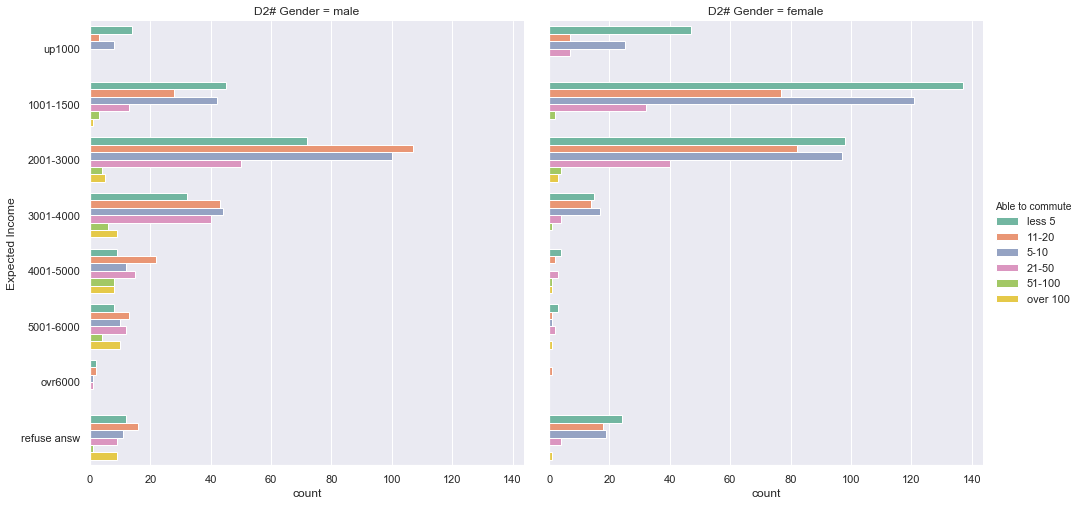

In [114]:
income_commute_plot('D2# Gender')

When we split responders by gender we see that they mostly differ in expected income distribution but commuting patterns remain almost the same with tendency for men to commute further, even over 100 km when expecting middle level income and above.

Further analysis can be made taking into account city size, age and so on.

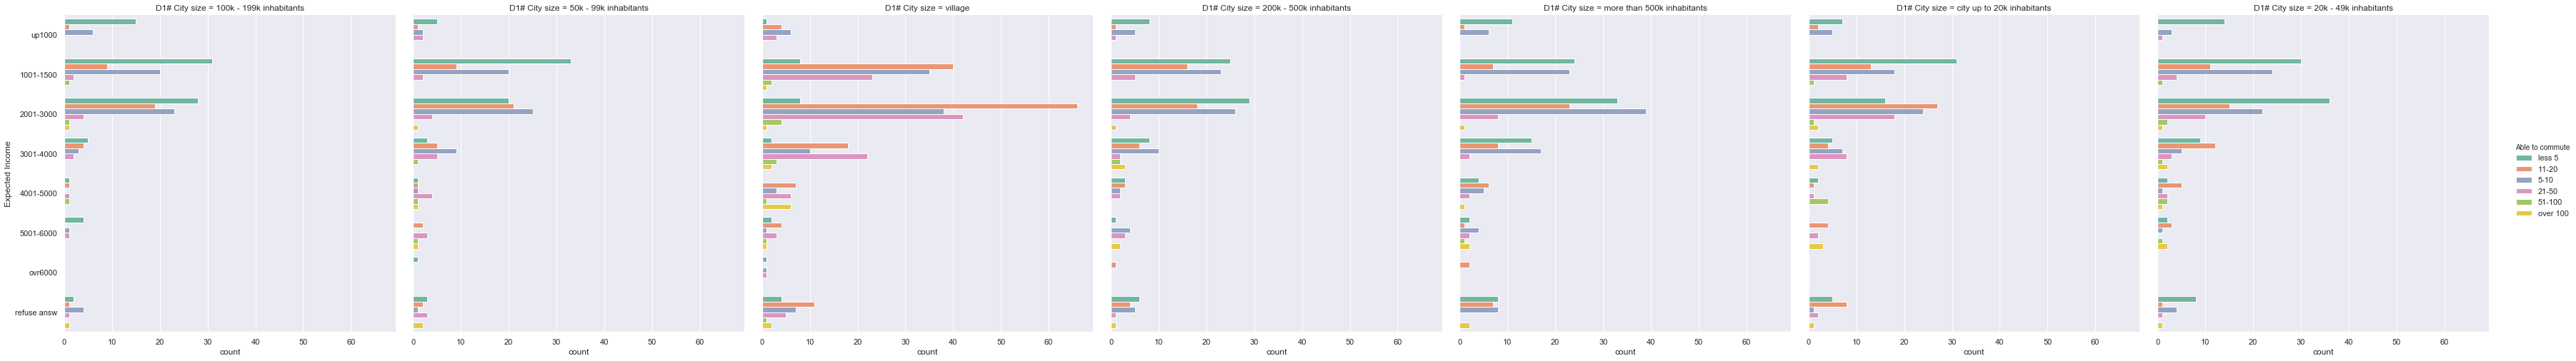

In [115]:
income_commute_plot('D1# City size')

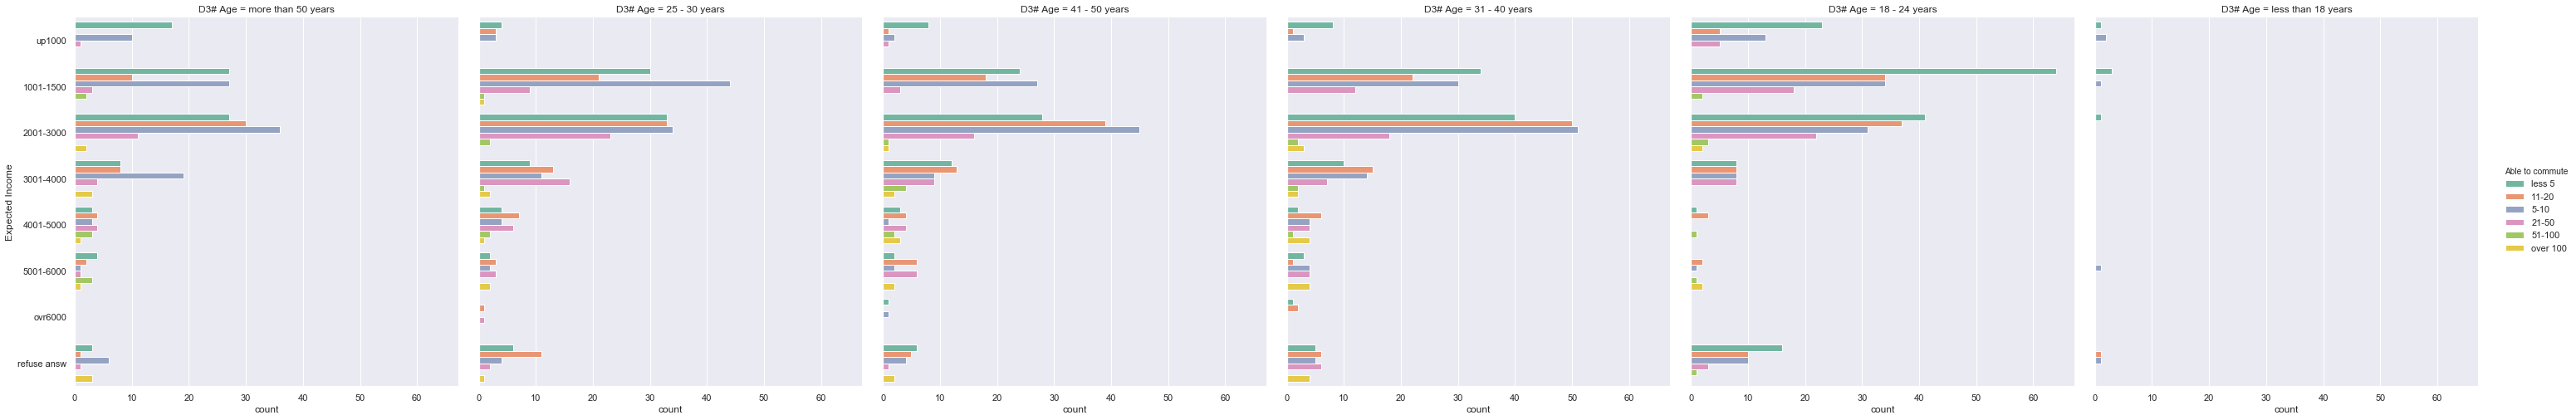

In [116]:
income_commute_plot('D3# Age')

# What is the key factor that determines the tendency to move closer to the work place (what is the most relevant factor influencing the will to move home closer work)?

<br><br><br>
**Conclusion:**

Two approaches - feature importance search and statistical tests - were used to spot the key factor that determines the tendency to move closer to the work place. The first approach was conducted on one-hot encoded dataset, and statistical tests were conducted on both rank-mapped and one-hot encoded datasets.

Using tree-based algorithm (RandomForest) resulted in selecting Top5 features in order of importance:
* Current income  up tp 1000 EUR
* Less than 5km living distance from work place
* Secondary grade education
* Age 18-24 years
* Able to commute between 5-10 km

However at this point the model is not stable and can not point exacly one, most important feature. Further analysis or approach change is needed if time allows.

Both Spearman's rank (for rank-mapped dataset) Pearson's (for one-hot encoded dataset) correlation tests together with Kruskal-Wallis test were used as statistical approach.

Resulted feature importances:
* Spearman's test - "Expected Income" and "Age"/"Able to commute"
* Pearson's test - "Able to commute over 100km"* and "Expected Income up to 1000 EUR"/"Expected Income 1001-1500 EUR"
* Kruskal-Wallis test - further analysis needed

There's also need for further statistical approach verification.

*seems to be not very intuitive

<br><br><br><br>

In [ ]:
df_closer_work = df_adult_all[df_adult_all['Are you keen on moving closer to your work place?'] == 'yes']
df_closer_work.head()

<br><br><br>
**Looking at the typical person keen to moving closer to the work place**

In [ ]:
df_closer_work.describe(exclude='number').T

In [ ]:
#     order = ['up1000', '1001-1500', '2001-3000','3001-4000','4001-5000','5001-6000','ovr6000','refuse answ']
sns.catplot(y='Able to commute', hue='D2# Gender', col='Are you keen on moving closer to your work place?',
                data=df_adult_all, kind="count",
                height=7, aspect=1, palette='Set2')
plt.show()

<br><br><br>
**Differences between groups that are and are not keen to move closer to work place**

In [ ]:
df_adult_all.groupby('Are you keen on moving closer to your work place?').describe(exclude='number').T

In [ ]:
# pd.crosstab(df_adult_all['Able to commute'], df_adult_all['Are you keen on moving closer to your work place?'],
#            normalize=False, margins=True)

### Trying with feature importance search

In [ ]:
df_adult_all.head(2)

In [ ]:
# Copy for rank remapping
df_adult_all_num = df_adult_all.copy()

# Copy for feature importance check with classification approach
df_adult_all_onehot = df_adult_all.copy()

**One-hot encoding for feature importance search**

In [ ]:
df_adult_all_onehot['Are you keen on moving closer to your work place?'] = df_adult_all_onehot['Are you keen on moving closer to your work place?'].map({'yes':1, 'no':0})

**Remapping ordinal features into ranks**

In [ ]:
df_adult_all_num['Are you keen on moving closer to your work place?'] = df_adult_all_num['Are you keen on moving closer to your work place?'].map({'yes':1, 'no':0})

df_adult_all_num['Are you looking for a job?'] = df_adult_all_num['Are you looking for a job?'].map({'yes':1, 'no':0})
df_adult_all_num['Q13-C22 - Do you work currently? - Answer'] = df_adult_all_num['Q13-C22 - Do you work currently? - Answer'].map({'yes':1, 'no':0})
df_adult_all_num['Have you ever worked before?'] = df_adult_all_num['Have you ever worked before?'].map({'yes':1, np.NaN:0})
df_adult_all_num['D2# Gender'] = df_adult_all_num['D2# Gender'].map({'male':1, 'female':0})
df_adult_all_num['D1# City size'] = df_adult_all_num['D1# City size'].map({
    'village':1,
    'city up to 20k inhabitants':2,
    '20k - 49k inhabitants':3,
    '50k - 99k inhabitants':4,
    '100k - 199k inhabitants':5,
    '200k - 500k inhabitants':6,
    'more than 500k inhabitants':7
})
df_adult_all_num['D3# Age'] = df_adult_all_num['D3# Age'].map({
    'less than 18 years':1,
    '18 - 24 years':2,
    '25 - 30 years':3,
    '31 - 40 years':4,
    '41 - 50 years':5,
    'more than 50 years':6
})
df_adult_all_num['D4# Education'] = df_adult_all_num['D4# Education'].map({
    'basic':1,
    'vocational':2,
    'secondary':3,
    'higher':4
})
df_adult_all_num['Current Income'] = df_adult_all_num['Current Income'].map({
    'refuse answ':1,
    'up1000':2,
    '1001-1500':3,
    '2001-3000':4,
    '3001-4000':5,
    '4001-5000':6,
    '5001-6000':7,
    'ovr6000':8
})
df_adult_all_num['Expected Income'] = df_adult_all_num['Expected Income'].map({
    'refuse answ':1,
    'up1000':2,
    '1001-1500':3,
    '2001-3000':4,
    '3001-4000':5,
    '4001-5000':6,
    '5001-6000':7,
    'ovr6000':8
})
df_adult_all_num['Living distance'] = df_adult_all_num['Living distance'].map({
    'less 5':1,
    '5-10':2,
    '11-20':3,
    '21-50':4,
    '51-100':5,
    'over 100':6
})
df_adult_all_num['Able to commute'] = df_adult_all_num['Able to commute'].map({
    'less 5':1,
    '5-10':2,
    '11-20':3,
    '21-50':4,
    '51-100':5,
    'over 100':6
})

In [ ]:
df_adult_all_num.head(2)

### Feature importance search with classification approach

In [ ]:
# Selecting categorical data 
data_categorical = df_adult_all_onehot.select_dtypes(exclude = ['number'])
data_categorical.head()

In [ ]:
df_adult_all_feature = pd.concat([df_adult_all_onehot['Are you keen on moving closer to your work place?'], 
                                  pd.get_dummies(data_categorical)], axis=1)

In [ ]:
df_adult_all_feature.head()

In [ ]:
data_train, data_test = train_test_split(df_adult_all_feature, test_size=0.3, shuffle=False)

In [ ]:
y_train = data_train.pop('Are you keen on moving closer to your work place?')
y_test = data_test.pop('Are you keen on moving closer to your work place?')

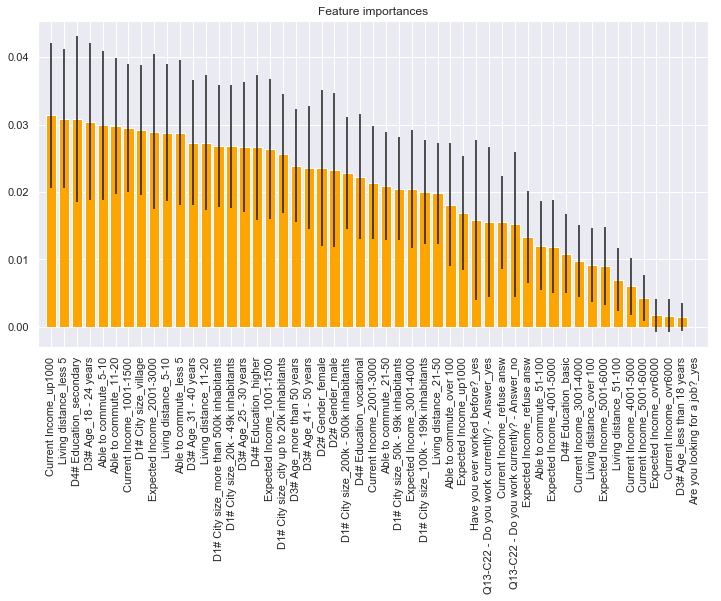

In [117]:
# Building model
forest = RandomForestClassifier(n_estimators=500,
                                random_state=42,
                                class_weight='balanced',
                                n_jobs=-1)

forest.fit(data_train, y_train)
importances = np.mean([tree.feature_importances_ for tree in forest.estimators_], axis=0)
stds = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
inds = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(data_train.shape[1]), importances[inds],
       color="orange", yerr=stds[inds], align="center")
plt.xticks(range(data_train.shape[1]), data_train.columns[inds], rotation='vertical')
plt.xlim([-1, data_train.shape[1]])
plt.show()

In [ ]:
print(classification_report(y_test, forest.predict(data_test)))

### Trying with some statistical tests

**Spearman's correlation**

In [ ]:
# Overall correlation

for col in df_adult_all_num.columns:
    if stats.spearmanr(df_adult_all_num['Are you keen on moving closer to your work place?'],
                      df_adult_all_num[col])[1] <= 0.05:
        print(stats.spearmanr(df_adult_all_num['Are you keen on moving closer to your work place?'],
                                                                       df_adult_all_num[col])[0],
             '  --- Spearman coeff. for', col)

**Pearson's correlation**

In [ ]:
# Specific features correlation

for col in df_adult_all_feature.columns:
    if stats.pearsonr(df_adult_all_feature['Are you keen on moving closer to your work place?'],
                      df_adult_all_feature[col])[1] <= 0.05:
        print(stats.pearsonr(df_adult_all_feature['Are you keen on moving closer to your work place?'],
                                                                       df_adult_all_feature[col])[0],
             '  --- Pearsons coeff. for', col)

**Kruskal - Wallis test**

In [ ]:
stats.kruskal(df_adult_all_num['Are you looking for a job?'],                      
df_adult_all_num['Q13-C22 - Do you work currently? - Answer'],         
df_adult_all_num['Have you ever worked before?'],                         
df_adult_all_num['Are you keen on moving closer to your work place?'],   
df_adult_all_num['D1# City size'],                                       
df_adult_all_num['D2# Gender'],                                           
df_adult_all_num['D3# Age'],                                             
df_adult_all_num['D4# Education'],                                       
df_adult_all_num['Current Income'],                                     
df_adult_all_num['Expected Income'],                                    
df_adult_all_num['Living distance'],                                     
df_adult_all_num['Able to commute'])              

In [ ]:
for col in df_adult_all_num.columns:
    print(stats.kruskal(df_adult_all_num['Are you keen on moving closer to your work place?'],
                  df_adult_all_num[col]), '----      ', col)